## Predict Sales for 1C
In this notebook we will focus on Feature Engineering and Modelling to predict sales for 1C during November 2015

See notebook PredictSales - EDA for a lot of the data exploration and analysis. Now that we understand the data better let's proceed with feature engineering


Problem description provided
I will work with a time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. I must predict total sales for every product and store in the next month. Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [1]:
# Import Required libraries

import numpy as np
import pandas as pd
import os
import pickle
import sys
import xgboost as xgb
import time
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from itertools import product
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, train_test_split, cross_val_score

print(os.listdir("../input"))

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


['sales_train.csv', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


### Load input data

In [2]:
items=pd.read_csv('../input/items.csv')
item_categories=pd.read_csv('../input/item_categories.csv')
shops=pd.read_csv('../input/shops.csv')
test=pd.read_csv('../input/test.csv')
sample_submission=pd.read_csv('../input/sample_submission.csv')
transactions=pd.read_csv('../input/sales_train.csv')

## EDA 
### See PredictSales - EDA notebook where we did a thorough exploration of the data

In [3]:
print(transactions.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


## FEATURE ENGINEERING

## 1. Merge sales training transactions with Items

In [4]:
# Remove outliers from test data 
transactions = transactions[transactions['item_cnt_day'] <= 1000]
transactions = transactions[transactions['item_price'] <= 100000]

In [5]:
#  Generate sales feature (Revenue = item count * item price)
transactions['item_sales'] = transactions['item_cnt_day'] * transactions['item_price']

In [6]:
# Left join transactions with Items
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions.head(2)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  03.01.2013               0       25     2552       899.0           1.0   

   item_sales  item_category_id  
0       999.0                37  
1       899.0                58

## 2. Combine shop_id, item_id for a date into a dataframe. 

In [7]:
# See Programming assignment week 3 
grid = []
unique_blocks = transactions['date_block_num'].unique()
for block in unique_blocks:
    current_shops = transactions.loc[transactions['date_block_num'] == block, 'shop_id'].unique()
    current_items = transactions.loc[transactions['date_block_num'] == block, 'item_id'].unique()
    grid.append(np.array(list(product(*[current_shops, current_items, [block]])), dtype='int32'))
    #print (grid)
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
print (grid.shape)
grid.head(2)

(10913804, 3)


shop_id  item_id  date_block_num
0       59    22154               0
1       59     2552               0

## 3. Create BLOCK_SHOP_ITEM  and BLOCK level features

### BLOCK_SHOP_ITEM level features

In [8]:
index_cols = ["date_block_num", "shop_id", "item_id"]
block_shop_item = transactions.groupby(index_cols).agg({
    'item_cnt_day':'sum','item_price':np.mean, 'item_sales':'sum'})
block_shop_item.rename(columns = {"item_cnt_day" :"bsi_cnt_month_sum", "item_sales" :"bsi_sales_month_sum", "item_price":"bsi_price_month_mean"}, inplace=True)
block_shop_item['bsi_cnt_month_sum'] = block_shop_item['bsi_cnt_month_sum'].clip(0,20)
block_shop_item.reset_index(inplace=True)



Merge this to grid and Fill NaN to zero.

In [9]:
train = pd.merge(grid,block_shop_item,on=index_cols,how='left')#.fillna(0)

In [10]:
del(block_shop_item)
block_shop_item = transactions.groupby(index_cols, as_index=False).agg({'item_cnt_day':'mean'})
block_shop_item.rename(columns = {"item_cnt_day" :"bsi_cnt_month_mean"}, inplace=True)
train = pd.merge(train, block_shop_item, how='left', on=index_cols)
del(block_shop_item)


### Merge with item and item_categories

In [11]:
train = pd.merge(train, items, on="item_id", how='left')
train = pd.merge(train, item_categories, on="item_category_id", how='left')

### BLOCK level features

In [12]:
index_cols = ["date_block_num"]
blk = transactions.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum','item_sales' : 'sum','item_price': 'mean'})
blk.rename(columns = {"item_cnt_day" :"b_cnt_month_sum", "item_sales" :"b_sales_month_sum", "item_price":"b_price_month_mean"}, inplace=True)
blk['b_cnt_month_sum'] = blk['b_cnt_month_sum'].clip(0,20)
train = pd.merge(train, blk, how='left', on=index_cols)
del(blk);

blk = transactions.groupby(index_cols, as_index=False).agg({'item_cnt_day':'mean'})
blk.rename(columns = {"item_cnt_day" :"b_cnt_month_mean"}, inplace=True)
train = pd.merge(train, blk, how='left', on=index_cols)
del(blk);

### BLOCK ITEM level features

In [13]:
index_cols = ["date_block_num", "item_id"]
blk_item = transactions.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum','item_sales' : 'sum','item_price': 'mean'})
blk_item.rename(columns = {"item_cnt_day" :"bi_cnt_month_sum", "item_sales" :"bi_sales_month_sum", "item_price":"bi_price_month_mean"}, inplace=True)
blk_item['bi_cnt_month_sum'] = blk_item['bi_cnt_month_sum'].clip(0,20)
train = pd.merge(train, blk_item, how='left', on=index_cols)
del(blk_item)

blk_item = transactions.groupby(index_cols, as_index=False).agg({'item_cnt_day':'mean'})
blk_item.rename(columns = {"item_cnt_day" :"bi_cnt_month_mean"}, inplace=True)
train = pd.merge(train, blk_item, how='left', on=index_cols)
del(blk_item)

###  MERGE TEST DATA
* Add block number 34 to test data for month of November
* Train data will now only shops and items we have in test.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 18 columns):
shop_id                 int32
item_id                 int32
date_block_num          int32
bsi_cnt_month_sum       float64
bsi_price_month_mean    float64
bsi_sales_month_sum     float64
bsi_cnt_month_mean      float64
item_name               object
item_category_id        int64
item_category_name      object
b_cnt_month_sum         float64
b_sales_month_sum       float64
b_price_month_mean      float64
b_cnt_month_mean        float64
bi_cnt_month_sum        float64
bi_sales_month_sum      float64
bi_price_month_mean     float64
bi_cnt_month_mean       float64
dtypes: float64(12), int32(3), int64(1), object(2)
memory usage: 1.4+ GB


In [15]:
test["date_block_num"] = 34
test_unique_shops = test.shop_id.unique()
test_unique_items = test.item_id.unique()

train = train[train['shop_id'].isin(test_unique_shops)]
train = train[train['item_id'].isin(test_unique_items)]
train.reset_index(inplace=True, drop=True)
train = pd.concat([train, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'] )
train.fillna(0, inplace=True)

In [16]:
# Save as we go
#train.to_pickle("../output/train0")
#train= pd.read_pickle("../output/train0")

## 4. LAG FEATURES

In [17]:
bsi_cols = ['date_block_num','shop_id','item_id'] 

In [18]:
'''
Function to create lags
'''
def create_lags (df, lags, cols):
    bsi_cols = ['date_block_num','shop_id','item_id'] 
    df_trim = df[bsi_cols + cols]
    for lag in lags:
        tmp = df_trim.copy()
        tmp.date_block_num += lag
        tmp.columns = bsi_cols + [ x + "_lag_" + str(lag) for x in cols]
        df = pd.merge(df, tmp, on=bsi_cols, how='left')
    return df

### CREATE MONTH lags for BLOCK_SHOP_ITEM (BSI) level features 

In [19]:
lags = [1, 2, 3, 6, 12]
cols_to_lag = ["bsi_cnt_month_sum", "bsi_price_month_mean", "bsi_sales_month_sum", "bsi_cnt_month_mean" ]
cols_with_keys = bsi_cols + cols_to_lag
tmp_df = create_lags(train[cols_with_keys], lags, cols_to_lag)
merge_cols = set(tmp_df.columns) - set(cols_to_lag)
train = pd.merge(train, tmp_df[merge_cols], how = 'left', on=bsi_cols)
del(tmp_df)

### CREATE MONTH lags for BLOCK(B) level features

In [20]:
lags = [1, 2, 3, 6, 12]
cols_to_lag = ["b_cnt_month_sum", "b_price_month_mean", "b_sales_month_sum", "b_cnt_month_mean" ]
cols_with_keys = bsi_cols + cols_to_lag
tmp_df = create_lags(train[cols_with_keys], lags, cols_to_lag)
merge_cols = set(tmp_df.columns) - set(cols_to_lag)
train = pd.merge(train, tmp_df[merge_cols], how = 'left', on=bsi_cols)
del(tmp_df)

### CREATE MONTH lags for BLOCK_ITEM  (BI) level features

In [21]:
lags = [1, 2, 3, 6, 12]
cols_to_lag = ["bi_cnt_month_sum", "bi_price_month_mean", "bi_sales_month_sum", "bi_cnt_month_mean" ]
cols_with_keys = bsi_cols + cols_to_lag
tmp_df = create_lags(train[cols_with_keys], lags, cols_to_lag)
merge_cols = set(tmp_df.columns) - set(cols_to_lag)
train = pd.merge(train, tmp_df[merge_cols], how = 'left', on=bsi_cols)
del(tmp_df)

In [22]:
# FILL NaNs with zero for lag columns
train.isnull().sum().sum()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if (('cnt_month' in col) or ('cnt_month_mean' in col )):
                df[col].fillna(0, inplace=True)       
    return df
train = fill_na(train)


In [23]:
## Adjust column types to shrink memory
for col in train.columns:
    if "sales" in col or 'price'in col:
        train[col] = train[col].astype('float64')
    elif 'cnt' in col:
        train[col] = train[col].astype('float32')
    elif 'tfidf' in col:
        train[col] = train[col].astype('float16')    
    elif train[col].dtype == 'float64':
        train[col] = train[col].astype('float16')
    elif col == 'item_id' or col == 'shop_id' or col == 'item_category_id' or col == 'date_block_num' :
        train[col] = train[col].astype('int16')
    elif train[col].dtype == 'int64':
        train[col] = train[col].astype('int8')

In [24]:
# Save as we go
#train.to_pickle("../output/train1")
#train = pd.read_pickle("../output/train1")

### 5. MEAN ENCODING 
#### REFERENCE: Mean encoding notebook lesson3 https://www.coursera.org/learn/competitive-data-science/notebook/3u0OE/mean-encoding-implementations-notebook

In [25]:
# Split your data in 5 folds with sklearn.model_selection.KFold with shuffle=False argument.
# Iterate through folds: use all but the current fold to calculate mean target for 
# each level item_id, and fill the current fold.
kf = KFold(n_splits=5)
train['itm_mnth_cnt_enc'] = 0
for trn_idx, tst_idx in kf.split(train):
    itm_mnth_cnt_mn = train.loc[trn_idx].groupby('item_id').bsi_cnt_month_sum.mean()
    train.loc[tst_idx, 'itm_mnth_cnt_enc'] = train.loc[tst_idx]['item_id'].map(itm_mnth_cnt_mn)
glbl_itm_mnth_cnt_mn = train['bsi_cnt_month_sum'].mean()
train['itm_mnth_cnt_enc'].fillna(glbl_itm_mnth_cnt_mn, inplace=True)
corr = np.corrcoef(train['bsi_cnt_month_sum'].values, train['itm_mnth_cnt_enc'].values)[0][1]
print(corr)

0.39715149898506225


In [26]:
# Save as we go
#train.to_pickle("../output/train2")
#train = pd.read_pickle("../output/train2")

### 6. TF_IDF from ITEM_NAME

In [27]:
itemid_name = items[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(itemid_name['item_name']).toarray())

cols = items_df_item_name_text_features.columns
for i in range(feature_count):
    feature_name = 'tfidf_item_name' + str(i)
    itemid_name[feature_name] = items_df_item_name_text_features[cols[i]]

itemid_name.drop('item_name', axis = 1, inplace = True)
train = train.merge(itemid_name, on = 'item_id', how = 'left')

### 7. PRICE CHANGE TRENDS in the PREVIOUS 3 months

In [28]:
lags = [1,2,3]
for i in lags:
    train['bi_delta_price_lag_'+str(i)] = \
        (train['bi_price_month_mean_lag_'+str(i)] - train['bi_price_month_mean']) / train['bi_price_month_mean']

def select_trend(row):
    for i in lags:
        if row['bi_delta_price_lag_'+str(i)]:
            return row['bi_delta_price_lag_'+str(i)]
    return 0
    
train['bi_delta_price_lag'] = train.apply(select_trend, axis=1)
train['bi_delta_price_lag'].fillna(0, inplace=True)
train['bi_delta_price_lag'].replace(np.inf, 0, inplace=True)

#### drop features temporary created to generate trend features
drop_features = []
for i in lags:
    drop_features += ['bi_delta_price_lag_'+str(i)]

train.drop(drop_features, axis=1, inplace=True)

### 8. CATEGORICAL FEATURE - Assign category Id to product names

In [29]:
## Source: Forum discussions
cat_nms = item_categories.item_category_name

cat_nms[0] = 'PC Headsets / Headphones'
cat_nms[1:8] = [item for item in ["Access"] for i in np.arange(1,8)]
cat_nms[8] = 'Tickets (figure)'
cat_nms[9] = 'Delivery of goods'
cat_nms[10:18] = [item for item in ["Consoles"] for i in np.arange(10,18)]
cat_nms[18:25] = [item for item in ['Consoles Games'] for i in np.arange(18,25)]
cat_nms[25] = 'Accessories for games'
cat_nms[26:28] = [item for item in ['phone games'] for i in np.arange(26,28)]
cat_nms[28:32] = [item for item in ['CD games'] for i in np.arange(28,32)]
cat_nms[32:37] = [item for item in ["Card"] for i in np.arange(32,37)]
cat_nms[37:43] = [item for item in ["Movie"] for i in np.arange(37,43)]

cat_nms[43:55] = [item for item in ["Books"] for i in np.arange(43,55)]
cat_nms[55:61] = [item for item in ["Music"] for i in np.arange(55,61)]
cat_nms[61:73] = [item for item in ["Gifts"] for i in np.arange(61,73)]
cat_nms[73:79] = [item for item in ["Soft"] for i in np.arange(73,79)]
cat_nms[79:81] = [item for item in ["Office"] for i in np.arange(79,81)]
cat_nms[81:83] = [item for item in ["Clean"] for i in np.arange(81,83)]
cat_nms[83] = 'Food'

item_categories["new_item_category_id"] = preprocessing.LabelEncoder().fit_transform(cat_nms)
train = pd.merge(train, item_categories[["item_category_id", "new_item_category_id"]], how="left", on="item_category_id")
_ = train.drop(['item_category_id'],axis=1, inplace=True)
train.rename(columns = {'new_item_category_id':'item_category_id'}, inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [30]:
# FILL NaNs with zero for lag columns
train.isnull().sum().sum()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if (('cnt_month' in col) or ('cnt_month_mean' in col )):
                df[col].fillna(0, inplace=True)       
    return df
train = fill_na(train)

In [31]:
## Adjust column types to shrink memory
for col in train.columns:
    if "sales" in col or 'price'in col:
        train[col] = train[col].astype('float64')
    elif 'cnt' in col:
        train[col] = train[col].astype('float32')
    elif 'tfidf' in col:
        train[col] = train[col].astype('float16')    
    elif train[col].dtype == 'float64':
        train[col] = train[col].astype('float16')
    elif col == 'item_id' or col == 'shop_id' or col == 'item_category_id' or col == 'date_block_num' :
        train[col] = train[col].astype('int16')
    elif train[col].dtype == 'int64':
        train[col] = train[col].astype('int8')

In [32]:
# Save as we go
#train.to_pickle("../output/train3")
#train = pd.read_pickle("../output/train3")

## 9. Drop columns that will not be used in training

In [33]:

drop_cols = ['bsi_price_month_mean', 'bsi_sales_month_sum', 'bsi_cnt_month_mean',
 'item_name', 'item_category_name', 'b_cnt_month_sum', 'b_sales_month_sum',
 'b_price_month_mean', 'b_cnt_month_mean', 'bi_cnt_month_sum',
 'bi_sales_month_sum', 'bi_price_month_mean', 'bi_cnt_month_mean', 'ID']

In [34]:
train.drop(drop_cols,axis=1,inplace=True)

In [40]:
# Save as we go
#train.to_pickle("../output/train4")
#train = pd.read_pickle("../output/train4")


In [41]:
train.shape


(2988638, 92)

## Train model using xgboost 

In [42]:
X_train = train[train['date_block_num'] < 33].drop(["bsi_cnt_month_sum"], axis=1)
y_train = train[train['date_block_num'] < 33]["bsi_cnt_month_sum"]
X_valdn = train[train['date_block_num'] == 33].drop(["bsi_cnt_month_sum"], axis=1)
y_valdn = train[train['date_block_num'] == 33]["bsi_cnt_month_sum"]
X_test = train[train['date_block_num'] == 34].drop(["bsi_cnt_month_sum"], axis=1)


In [44]:
ts = time.time()
os.environ['KMP_DUPLICATE_LIB_OK']='True'
xgb_model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1,
                             eta = 0.3, n_estimators=100, seed = 1, nthread = 5)

xgb_fit = xgb_model.fit(X_train,y_train,
                         eval_set=[(X_train,y_train), (X_valdn, y_valdn)],
                         eval_metric='rmse',
                         early_stopping_rounds=10)
time.time() - ts

[0]	validation_0-rmse:1.41335	validation_1-rmse:1.10060
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.25553	validation_1-rmse:1.03135
[2]	validation_0-rmse:1.15996	validation_1-rmse:0.99967
[3]	validation_0-rmse:1.09866	validation_1-rmse:0.98192
[4]	validation_0-rmse:1.05720	validation_1-rmse:0.95988
[5]	validation_0-rmse:1.03137	validation_1-rmse:0.95631
[6]	validation_0-rmse:1.01207	validation_1-rmse:0.95503
[7]	validation_0-rmse:0.99429	validation_1-rmse:0.95569
[8]	validation_0-rmse:0.98027	validation_1-rmse:0.95321
[9]	validation_0-rmse:0.96627	validation_1-rmse:0.94987
[10]	validation_0-rmse:0.95611	validation_1-rmse:0.95067
[11]	validation_0-rmse:0.94832	validation_1-rmse:0.94832
[12]	validation_0-rmse:0.94060	validation_1-rmse:0.94857
[13]	validation_0-rmse:0.93461	validation_1-rmse:0.94640
[14]	validation_0-rmse:0.92780	validation_1-rmse:0.94

249.10820078849792

In [45]:
# Save the Model to file
with open("../output/xgb_model", 'wb') as file:  
    pickle.dump(xgb_model, file)
    
# Load the Model back from file
#with open("../output/xgb_model", 'rb') as file:  
#    xgb_model = pickle.load(file)

In [46]:
y_predValdn = xgb_model.predict(X_valdn)
print("Validation rmse: ", np.sqrt(mean_squared_error(y_valdn, y_predValdn)))

Validation rmse:  0.94429064
62815.754
0.37474647


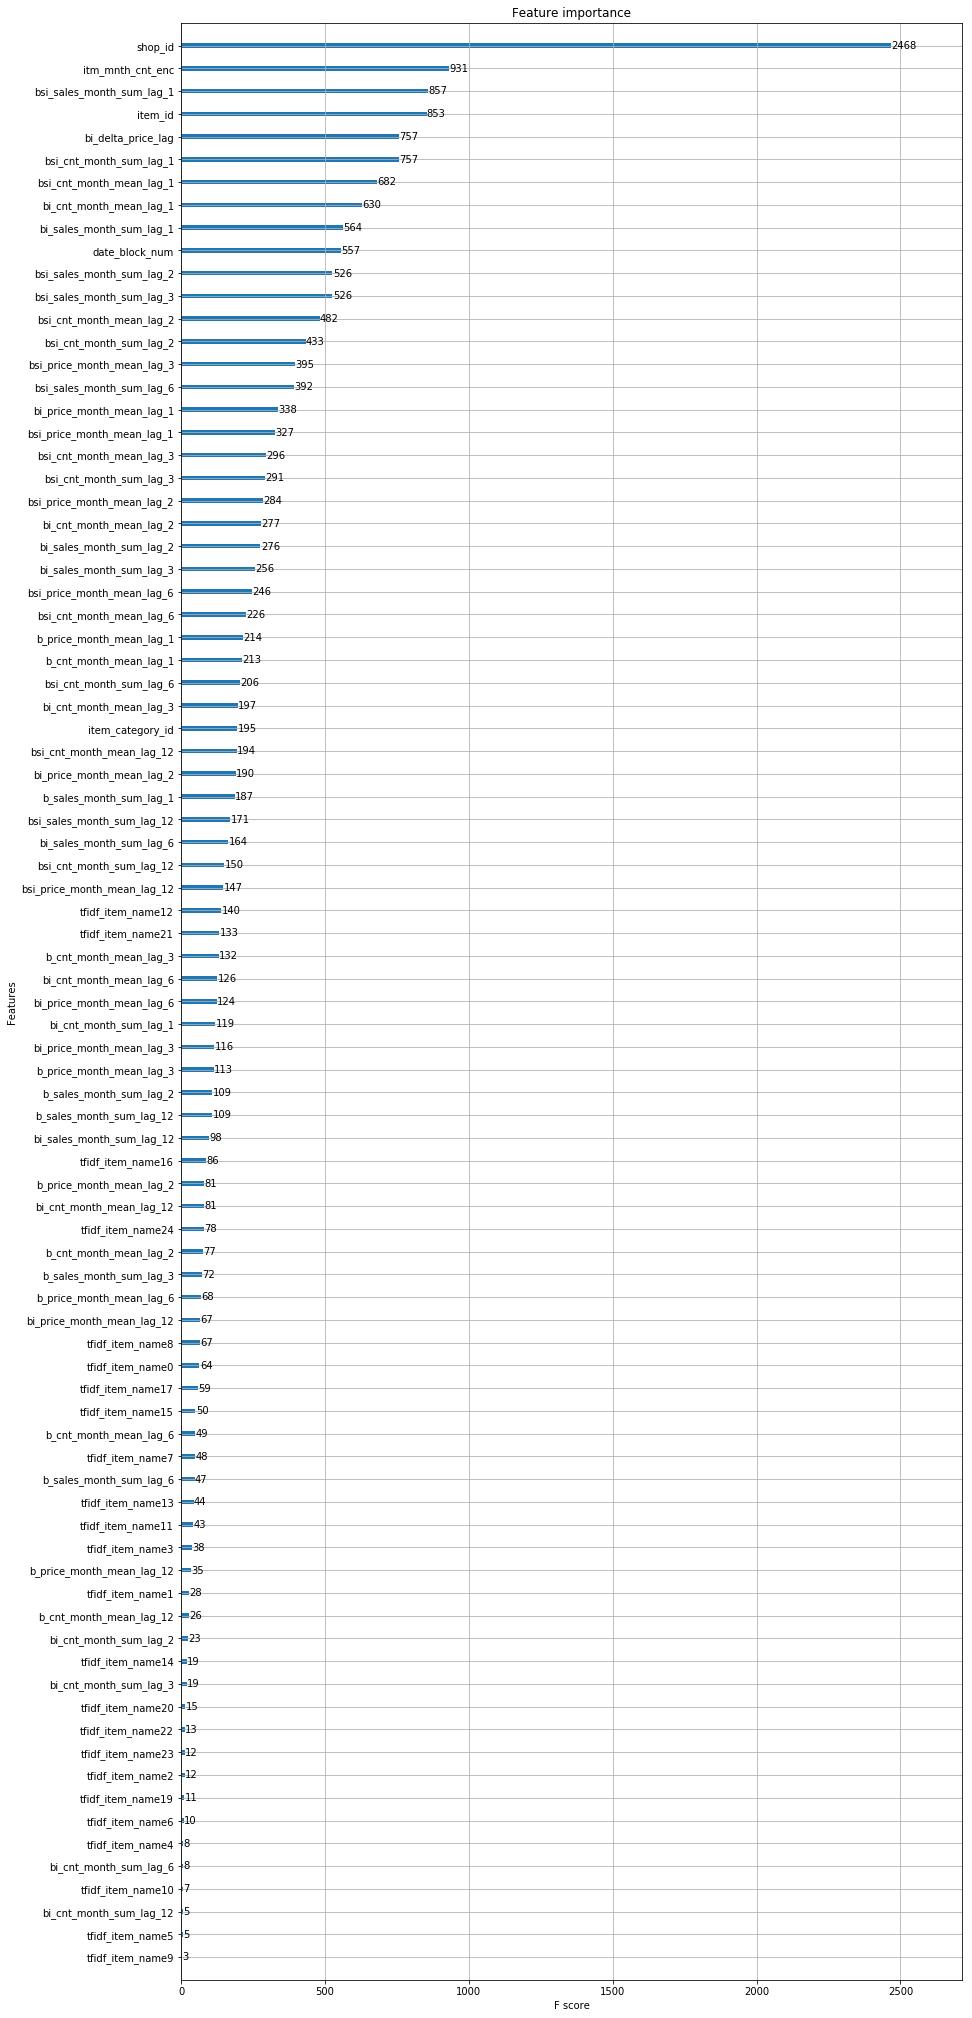

In [47]:
fig, ax = plt.subplots(figsize=(14,36))
xgb.plot_importance(xgb_model, ax);

In [48]:
y_pred = xgb_model.predict(X_test)

In [49]:
y_pred = np.clip(y_pred, 0,20)
df = pd.DataFrame(y_pred, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('../output/submission_xgboost_5.csv')

Your public and private LB scores are: 0.996306 and 0.985225